# Info

https://github.com/shivaverma/OpenAIGym/blob/master/cart-pole/CartPole-v0.py

In [1]:
import gym
import random
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# disable eager execution to speed up
tf.compat.v1.disable_eager_execution()

tf.__version__

'2.2.0'

In [2]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        """Also called 'Replay Memory' it's designed to store previous
            observation, action, reward, next-observation values.
         The DQN needs experience replay to reduce correlations in 
             the sequence of observations, which otherwise might drive 
             the network into a local minimum.
        """
        # when buffer gets full it goes back and re-writes again
        self.mem_size = max_size
        # position of first unsaved memory
        self.mem_cntr = 0
        self.discrete = discrete
        self.observation_memory = np.zeros((self.mem_size, input_shape))
        self.new_observation_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        # keep track of our `done` flags becuase the value of the terminal state is 0.
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def collect_experience(self, state, action, reward, state_, done):
        """ Populate the replay memory with initial experience.
        """
        index = self.mem_cntr % self.mem_size
        self.observation_memory[index] = state
        self.new_observation_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        # when episode done is 'True'. Use this to multiple the reward.
        #  If reached temrinal state we don't give any reward (reward 0)
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        """Sample memory buffer."""
        max_mem = min(self.mem_cntr, self.mem_size)
        # replace will detemrine if reuse examples if already sampled
        batch = np.random.choice(max_mem, batch_size, replace=False)

        observations = self.observation_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_observations = self.new_observation_memory[batch]
        terminal = self.terminal_memory[batch]

        return observations, actions, rewards, new_observations, terminal


In [6]:
class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.epsilon_decay = .995
        self.learning_rate = 0.001
#         self.memory = deque(maxlen=10000)
        self.memory = ReplayBuffer(10000, state_space, action_space,
                                   discrete=True)
        self.model = self.build_model()

    def build_model(self):

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(24, input_shape=(self.state_space,), activation='relu'))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.collect_experience(state, action, reward, next_state, done)
#         self.memory.append((state, action, reward, next_state, done))

    def act(self, state, use_exploration=True):

        if use_exploration and (np.random.rand() <= self.epsilon):
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if self.memory.mem_cntr < self.batch_size:
            return
        
        observation, action, reward, new_observation, done = \
                                      self.memory.sample_buffer(self.batch_size)

        action_values = np.array(list(range(self.action_space)), dtype=np.int8)
        # from one-hot to indeces
        action_indices = np.dot(action, action_values)

        # use target model as policy
        q_eval = self.model.predict(observation)
        # make copy in order to change it later
        q_target = q_eval.copy()
        # get Q-values for new observation
        q_next = self.model.predict(new_observation)

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        # create Q-values. No reward for ending states.
        q_target[batch_index, action_indices] = reward + \
                              self.gamma*np.max(q_next, axis=1)*done
        # fit batch to online-model
        _ = self.model.fit(observation, q_target, verbose=0)
        
        self.epsilon = self.epsilon*self.epsilon_decay if self.epsilon > self.epsilon_min else self.epsilon_min
#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay


def train_dqn(episode):

    loss = []
    test_loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    test_env = gym.make('CartPole-v0')
    test_env.seed(0)
    np.random.seed(0)

    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 4))
        score = 0
        max_steps = 1000
        for i in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 4))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}, epsilon {:.3f}".format(e, episode, score, agent.epsilon))
                break
        test_loss.append(test_dqn(test_env, 10, agent, False))
        loss.append(score)
    return loss, test_loss, agent

def test_dqn(env, episode, agent, verbose=True):

    loss = []
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 4))
        score = 0
        max_steps = 1000
        for i in range(max_steps):
            action = agent.act(state, use_exploration=False)
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 4))
            state = next_state
            if done and verbose:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)
    return loss

def random_policy(episode, step):

    for i_episode in range(episode):
        env.reset()
        for t in range(step):
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
            print("Starting next episode")

episode: 0/100, score: 22.0, epsilon 1.000


/users/yby1/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode: 1/100, score: 28.0, epsilon 1.000
episode: 2/100, score: 13.0, epsilon 1.000
episode: 3/100, score: 9.0, epsilon 0.956
episode: 4/100, score: 10.0, epsilon 0.909
episode: 5/100, score: 22.0, epsilon 0.814
episode: 6/100, score: 17.0, epsilon 0.748
episode: 7/100, score: 16.0, epsilon 0.690
episode: 8/100, score: 10.0, epsilon 0.656
episode: 9/100, score: 29.0, epsilon 0.568
episode: 10/100, score: 14.0, epsilon 0.529
episode: 11/100, score: 11.0, epsilon 0.501
episode: 12/100, score: 17.0, epsilon 0.460
episode: 13/100, score: 12.0, epsilon 0.433
episode: 14/100, score: 9.0, epsilon 0.414
episode: 15/100, score: 14.0, epsilon 0.386
episode: 16/100, score: 12.0, epsilon 0.363
episode: 17/100, score: 23.0, epsilon 0.324
episode: 18/100, score: 12.0, epsilon 0.305
episode: 19/100, score: 9.0, epsilon 0.291
episode: 20/100, score: 10.0, epsilon 0.277
episode: 21/100, score: 21.0, epsilon 0.249
episode: 22/100, score: 32.0, epsilon 0.212
episode: 23/100, score: 44.0, epsilon 0.170


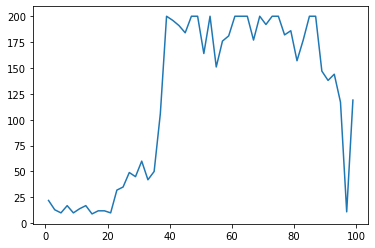

In [7]:
env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

agent = DQN(env.action_space.n, env.observation_space.shape[0])


ep = 100
loss, test_loss, agent = train_dqn(ep)
plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
plt.show()

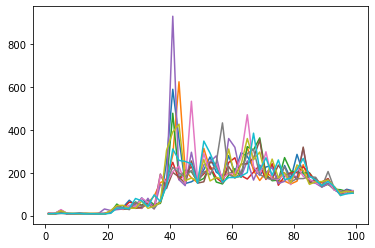

In [8]:
plt.plot([i+1 for i in range(0, ep, 2)], test_loss[::2])
plt.show()

In [ ]:
env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

ep = 20
loss = test_dqn(env, ep, agent)
plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
plt.show()

np.mean(loss)